In [20]:
from qiskit import QuantumCircuit

def get_qc_for_n_qubit_GHZ_state(n: int) -> QuantumCircuit:
    """ This function creates a Quantum Circuit for a n-qubit GHZ State 
    Args:
        n (int): Number of qubits in the n-qubit GHZ State

    Returns:
        QuantumCircuit: Quantum circuit that generates the n-qubit GHZ State
    """
    if isinstance(n, int) and n >= 2:
        qc = QuantumCircuit(n)
        qc.h(0)
        for i in range(n-1):
            qc.cx(i, i+1)
    else:
        raise Exception("n is not a valid input")
    
    return qc

In [21]:
n = 100
qc = get_qc_for_n_qubit_GHZ_state(n)

In [22]:
from qiskit.quantum_info import SparsePauliOp

operator_strings = [
    "Z" + "I" * i + "Z" + "I" * (n - 2 - i) for i in range(n-1)
]
print(len(operator_strings))

operators = [SparsePauliOp(operator) for operator in operator_strings]

99


In [23]:
# fetching the api key from env
from dotenv import load_dotenv
load_dotenv(".env")
from os import getenv

TOKEN = getenv("TOKEN")
if not TOKEN:
    print("error: TOKEN not set in env")

In [24]:
# optimizing for running on hardware
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum", token=TOKEN)

backend = service.least_busy(
    simulator = False, operational=True, min_num_qubits=100
)
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)

isa_circuit = pm.run(qc)
isa_operators_list = [op.apply_layout(isa_circuit.layout) for op in operators]

In [25]:
from qiskit_ibm_runtime import EstimatorOptions
from qiskit_ibm_runtime import EstimatorV2 as Estimator

options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

# creating an estimator
estimator = Estimator(backend, options = options)

In [26]:
# submitting the job to estimator
job = estimator.run([(isa_circuit, isa_operators_list)])
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: cwyc3j6997wg008y6wr0


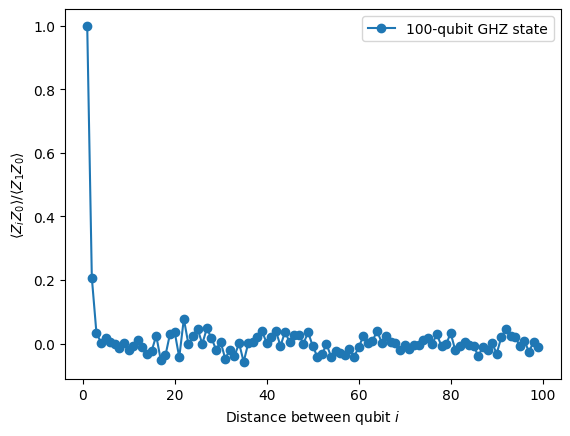

In [27]:
# post processing results
import matplotlib.pyplot as plt

data = list(range(1, len(operators) + 1))
result = job.result()[0]
values = result.data.evs
values = [
    v / values[0] for v in values
]     # normalizing the expectation values to evaluate how they decay with distance

# plotting
plt.plot(data, values, marker="o", label="100-qubit GHZ state")
plt.xlabel("Distance between qubit $i$")
plt.ylabel(r"$\langle Z_i Z_0 \rangle / \langle Z_1 Z_0 \rangle $")
plt.legend()
plt.show()
            